# Intersection with a crosswalk

**Load dependencies**

In [1]:
rng = MersenneTwister(1);

In [2]:
using AutomotivePOMDPs
using MDPModelChecking

The method will not be callable.


In [3]:
using GridInterpolations, StaticArrays, POMDPs, POMDPToolbox, AutoViz, AutomotiveDrivingModels, Reel
using DeepRL, DeepQLearning
using DiscreteValueIteration
using ProgressMeter, Parameters, JLD

In [14]:
include("util.jl")
include("masking_backup.jl")
include("masked_dqn.jl")
include("render_helpers.jl")

## Scenario in the Continuous Space

In [5]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =  [VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

## Discrete Fully Observable abstraction - Car MDP 

In [6]:
mdp = CarMDP(env = env, vel_res=2., pos_res=2.);
labels = labeling(mdp);
@printf("spatial resolution %2.1f m \n", mdp.pos_res)
@printf("car velocity resolution %2.1f m \n", mdp.vel_res)
@printf("number of states %d \n", n_states(mdp))
@printf("number of actions %d \n", n_actions(mdp))

property = "Pmax=? [ (!\"crash\") U \"goal\"]" 
threshold = 0.9999
@printf("Spec: %s \n", property)
@printf("Threshold: %f \n", threshold)

println("Model checking...")
result = model_checking(mdp, labels, property, transition_file_name="carmdp2.tra", labels_file_name="carmdp2.lab", overwrite=true);

spatial resolution 2.0 m 
car velocity resolution 2.0 m 
number of states 161772 
number of actions 4 
Spec: Pmax=? [ (!"crash") U "goal"] 
Threshold: 0.999900 
Model checking...


28-Jun 01:00:15:WARNING:root:overwriting potential existing files!


In [7]:
mask = nothing # declare
mask_file = "carmask2.jld"
if isfile(mask_file) && false
    println("Loading safety mask from carmask.jld")
    mask_data = JLD.load(mask_file)
    mask = SafetyMask(mdp, StormPolicy(mdp, mask_data["risk_vec"], mask_data["risk_mat"]), threshold)
    @printf("Mask threshold %f", mask.threshold)
else
    println("Computing Safety Mask...")
    mask = SafetyMask(mdp, StormPolicy(mdp, result), threshold);
    JLD.save(mask_file, "risk_vec", mask.policy.risk_vec, "risk_mat", mask.policy.risk_mat)
    println("Mask saved.")
end

Computing Safety Mask...
Mask saved.


In [8]:
rand_pol = MaskedEpsGreedyPolicy(mask.mdp, 1.0, mask, rng);

28-Jun 10:11:42:WARNING:root:replacing docs for 'AutomotivePOMDPs.stop_at_dist :: Tuple{AutomotiveDrivingModels.DriverModel,Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},Float64}' in module 'AutomotivePOMDPs'.


In [9]:
rng = MersenneTwister(2)
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(mdp, rng)
hist2 = simulate(hr, mdp, rand_pol, s0);

In [10]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, CarMDPAction(NaN))
duration, fps, render_hist = animate_states(mdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpx6Jkt4", 0x0000000000000039, 2.0, nothing)

Try to generate a collision

In [11]:
@time for ep=1:10
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initialstate(mdp, rng)
    hist2 = simulate(hr, mdp, rand_pol, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

  1.711944 seconds (1.59 M allocations: 67.229 MiB, 13.45% gc time)


Evaluate the mask

In [12]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(mdp, rand_pol, n_ep=1000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

 10.573252 seconds (130.30 M allocations: 5.461 GiB, 22.05% gc time)
Summary for 1000 episodes: 
Average reward: 0.078 
Average # of steps: 66.703 
Average # of violations: 0.000 


## Use the mask in a higher fidelity environment

In [15]:
pomdp = UrbanPOMDP(env=env,
                   ego_goal = LaneTag(2, 1),
                   max_cars=1, 
                   max_peds=0, 
                   car_birth=0.7, 
                   ped_birth=0.3, 
                   obstacles=false, # no fixed obstacles
                   lidar=false,
                   pos_obs_noise = 0., # fully observable
                   vel_obs_noise = 0.);

In [16]:
rand_pol = RandomMaskedPOMDPPolicy(mask, pomdp, rng);

In [19]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(pomdp, rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0);

  0.098983 seconds (1.14 M allocations: 38.706 MiB, 11.43% gc time)


In [20]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
safe_acts = h.ainfo_hist
push!(action_hist, CarMDPAction(NaN))
push!(safe_acts, [CarMDPAction(NaN)])
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, safe_acts, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpPevBFO", 0x000000000000002c, 2.0, nothing)

In [21]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

2168.896975 seconds (19.99 G allocations: 661.580 GiB, 18.83% gc time)
Summary for 10000 episodes: 
Average reward: 0.048 
Average # of steps: 76.278 
Average # of violations: 0.000 


In [18]:
@time for ep=1:10000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initialstate(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

2083.

529815 seconds (20.10 G allocations: 663.650 GiB, 18.01% gc time)


In [24]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

2388.019712 seconds (22.29 G allocations: 679.861 GiB, 15.27% gc time)
Summary for 10000 episodes: 
Average reward: 0.032 
Average # of steps: 82.517 
Average # of violations: 0.000 


Get the environment ready to apply DQN

In [15]:
env = POMDPEnvironment(pomdp);

**Train!**

In [16]:
max_steps = 500000
eps_fraction = 0.5 
eps_end = 0.01 
solver = DeepQLearningSolver(max_steps = max_steps, eps_fraction = eps_fraction, eps_end = eps_end,
                       lr = 0.0001,                    
                       batch_size = 32,
                       target_update_freq = 5000,
                       max_episode_length = 200,
                       train_start = 40000,
                       buffer_size = 400000,
                       eval_freq = 10000,
                       arch = QNetworkArchitecture(conv=[], fc=[32,32,32]),
                       double_q = true,
                       dueling = true,
                       prioritized_replay = true,
                       exploration_policy = masked_linear_epsilon_greedy(max_steps, eps_fraction, eps_end, mask),
                       evaluation_policy = masked_evaluation(mask),
                       verbose = true,
                       logdir = "carmdp-log/log4",
                       rng = rng)
;

In [19]:
policy = solve(solver, env)

  100 / 500000 eps 9.996e-01 |  avgR 5.000e-01 | Loss 3.349e-03 | Grad 5.870e-03
  200 / 500000 eps 9.992e-01 |  avgR 6.667e-01 | Loss 2.208e-03 | Grad 3.434e-03
  300 / 500000 eps 9.988e-01 |  avgR 7.500e-01 | Loss 3.750e-03 | Grad 3.716e-03
  400 / 500000 eps 9.984e-01 |  avgR 8.000e-01 | Loss 3.697e-03 | Grad 4.287e-03
  500 / 500000 eps 9.980e-01 |  avgR 8.333e-01 | Loss 1.951e-03 | Grad 1.876e-03
  600 / 500000 eps 9.976e-01 |  avgR 8.750e-01 | Loss 3.814e-03 | Grad 4.342e-03
  700 / 500000 eps 9.972e-01 |  avgR 8.889e-01 | Loss 2.757e-03 | Grad 1.336e-03
  800 / 500000 eps 9.968e-01 |  avgR 9.091e-01 | Loss 3.430e-03 | Grad 4.678e-03
  900 / 500000 eps 9.964e-01 |  avgR 9.231e-01 | Loss 2.794e-03 | Grad 3.361e-03
 1000 / 500000 eps 9.960e-01 |  avgR 9.286e-01 | Loss 2.251e-03 | Grad 1.445e-03
 1100 / 500000 eps 9.956e-01 |  avgR 9.333e-01 | Loss 2.476e-03 | Grad 2.840e-03
 1200 / 500000 eps 9.952e-01 |  avgR 9.412e-01 | Loss 2.547e-03 | Grad 2.288e-03
 1300 / 500000 eps 9.949e-01

10200 / 500000 eps 9.596e-01 |  avgR 9.706e-01 | Loss 3.721e-04 | Grad 4.497e-03
10300 / 500000 eps 9.592e-01 |  avgR 9.706e-01 | Loss 1.316e-04 | Grad 4.138e-03
10400 / 500000 eps 9.588e-01 |  avgR 9.706e-01 | Loss 1.361e-04 | Grad 1.227e-02
10500 / 500000 eps 9.584e-01 |  avgR 9.804e-01 | Loss 2.167e-04 | Grad 5.311e-03
10600 / 500000 eps 9.580e-01 |  avgR 9.804e-01 | Loss 2.384e-04 | Grad 3.588e-03
10700 / 500000 eps 9.576e-01 |  avgR 9.804e-01 | Loss 4.974e-04 | Grad 1.234e-02
10800 / 500000 eps 9.572e-01 |  avgR 9.804e-01 | Loss 1.873e-04 | Grad 3.691e-03
10900 / 500000 eps 9.568e-01 |  avgR 9.804e-01 | Loss 1.971e-04 | Grad 2.429e-03
11000 / 500000 eps 9.564e-01 |  avgR 9.804e-01 | Loss 1.555e-04 | Grad 5.830e-03
11100 / 500000 eps 9.560e-01 |  avgR 9.804e-01 | Loss 2.094e-04 | Grad 7.021e-03
11200 / 500000 eps 9.556e-01 |  avgR 9.804e-01 | Loss 2.071e-04 | Grad 7.361e-03
11300 / 500000 eps 9.553e-01 |  avgR 9.804e-01 | Loss 1.337e-04 | Grad 6.677e-03
11400 / 500000 eps 9.549e-01

20300 / 500000 eps 9.196e-01 |  avgR 9.804e-01 | Loss 7.204e-05 | Grad 6.308e-03
20400 / 500000 eps 9.192e-01 |  avgR 9.804e-01 | Loss 3.878e-05 | Grad 2.002e-03
20500 / 500000 eps 9.188e-01 |  avgR 9.804e-01 | Loss 1.486e-04 | Grad 1.926e-03
20600 / 500000 eps 9.184e-01 |  avgR 9.804e-01 | Loss 4.830e-05 | Grad 3.170e-03
20700 / 500000 eps 9.180e-01 |  avgR 9.804e-01 | Loss 7.322e-05 | Grad 5.246e-03
20800 / 500000 eps 9.176e-01 |  avgR 9.902e-01 | Loss 1.279e-04 | Grad 3.647e-03
20900 / 500000 eps 9.172e-01 |  avgR 9.902e-01 | Loss 7.929e-05 | Grad 5.859e-03
21000 / 500000 eps 9.168e-01 |  avgR 9.902e-01 | Loss 8.001e-05 | Grad 3.459e-03
21100 / 500000 eps 9.164e-01 |  avgR 9.902e-01 | Loss 4.752e-05 | Grad 3.060e-03
21200 / 500000 eps 9.160e-01 |  avgR 9.902e-01 | Loss 5.573e-05 | Grad 2.055e-03
21300 / 500000 eps 9.157e-01 |  avgR 9.902e-01 | Loss 9.142e-05 | Grad 7.568e-03
21400 / 500000 eps 9.153e-01 |  avgR 9.902e-01 | Loss 2.327e-04 | Grad 5.130e-03
21500 / 500000 eps 9.149e-01

30400 / 500000 eps 8.796e-01 |  avgR 9.902e-01 | Loss 6.479e-05 | Grad 3.421e-03
30500 / 500000 eps 8.792e-01 |  avgR 9.902e-01 | Loss 6.821e-05 | Grad 4.656e-03
30600 / 500000 eps 8.788e-01 |  avgR 9.902e-01 | Loss 1.150e-04 | Grad 4.514e-03
30700 / 500000 eps 8.784e-01 |  avgR 9.902e-01 | Loss 2.848e-04 | Grad 1.189e-02
30800 / 500000 eps 8.780e-01 |  avgR 9.902e-01 | Loss 6.495e-05 | Grad 7.889e-03
30900 / 500000 eps 8.776e-01 |  avgR 9.902e-01 | Loss 2.341e-05 | Grad 1.670e-03
31000 / 500000 eps 8.772e-01 |  avgR 9.902e-01 | Loss 1.753e-04 | Grad 1.105e-02
31100 / 500000 eps 8.768e-01 |  avgR 9.902e-01 | Loss 1.376e-04 | Grad 3.076e-03
31200 / 500000 eps 8.764e-01 |  avgR 9.902e-01 | Loss 1.083e-04 | Grad 8.140e-03
31300 / 500000 eps 8.761e-01 |  avgR 9.902e-01 | Loss 1.078e-04 | Grad 9.075e-03
31400 / 500000 eps 8.757e-01 |  avgR 9.902e-01 | Loss 1.672e-04 | Grad 9.588e-03
31500 / 500000 eps 8.753e-01 |  avgR 9.902e-01 | Loss 4.288e-05 | Grad 2.560e-03
31600 / 500000 eps 8.749e-01

40500 / 500000 eps 8.396e-01 |  avgR 9.902e-01 | Loss 5.590e-05 | Grad 4.338e-03
40600 / 500000 eps 8.392e-01 |  avgR 9.902e-01 | Loss 1.749e-04 | Grad 5.527e-03
40700 / 500000 eps 8.388e-01 |  avgR 9.902e-01 | Loss 8.344e-05 | Grad 7.313e-03
40800 / 500000 eps 8.384e-01 |  avgR 9.902e-01 | Loss 1.496e-04 | Grad 1.133e-02
40900 / 500000 eps 8.380e-01 |  avgR 9.902e-01 | Loss 1.045e-04 | Grad 3.703e-03
41000 / 500000 eps 8.376e-01 |  avgR 9.902e-01 | Loss 6.504e-05 | Grad 3.219e-03
41100 / 500000 eps 8.372e-01 |  avgR 9.902e-01 | Loss 6.568e-05 | Grad 7.486e-03
41200 / 500000 eps 8.368e-01 |  avgR 9.902e-01 | Loss 7.515e-05 | Grad 2.754e-03
41300 / 500000 eps 8.365e-01 |  avgR 9.902e-01 | Loss 4.086e-05 | Grad 2.958e-03
41400 / 500000 eps 8.361e-01 |  avgR 9.902e-01 | Loss 1.450e-04 | Grad 1.121e-02
41500 / 500000 eps 8.357e-01 |  avgR 9.902e-01 | Loss 4.078e-05 | Grad 2.235e-03
41600 / 500000 eps 8.353e-01 |  avgR 9.902e-01 | Loss 3.042e-05 | Grad 1.855e-03
41700 / 500000 eps 8.349e-01

50600 / 500000 eps 7.996e-01 |  avgR 9.902e-01 | Loss 5.838e-05 | Grad 3.429e-03
50700 / 500000 eps 7.992e-01 |  avgR 9.902e-01 | Loss 1.195e-04 | Grad 2.927e-03
50800 / 500000 eps 7.988e-01 |  avgR 9.902e-01 | Loss 1.100e-04 | Grad 6.438e-03
50900 / 500000 eps 7.984e-01 |  avgR 9.902e-01 | Loss 1.176e-04 | Grad 1.310e-02
51000 / 500000 eps 7.980e-01 |  avgR 9.902e-01 | Loss 8.056e-05 | Grad 5.839e-03
51100 / 500000 eps 7.976e-01 |  avgR 9.902e-01 | Loss 6.714e-05 | Grad 4.092e-03
51200 / 500000 eps 7.972e-01 |  avgR 9.902e-01 | Loss 2.796e-04 | Grad 2.051e-02
51300 / 500000 eps 7.969e-01 |  avgR 9.902e-01 | Loss 2.531e-04 | Grad 1.374e-02
51400 / 500000 eps 7.965e-01 |  avgR 9.902e-01 | Loss 2.272e-04 | Grad 4.039e-03
51500 / 500000 eps 7.961e-01 |  avgR 9.902e-01 | Loss 1.321e-04 | Grad 8.846e-03
51600 / 500000 eps 7.957e-01 |  avgR 9.804e-01 | Loss 9.178e-05 | Grad 8.812e-03
51700 / 500000 eps 7.953e-01 |  avgR 9.804e-01 | Loss 4.431e-05 | Grad 1.347e-03
51800 / 500000 eps 7.949e-01

60700 / 500000 eps 7.596e-01 |  avgR 9.902e-01 | Loss 1.470e-04 | Grad 1.200e-02
60800 / 500000 eps 7.592e-01 |  avgR 9.902e-01 | Loss 3.241e-05 | Grad 3.586e-03
60900 / 500000 eps 7.588e-01 |  avgR 9.902e-01 | Loss 1.180e-04 | Grad 5.142e-03
61000 / 500000 eps 7.584e-01 |  avgR 9.902e-01 | Loss 5.384e-05 | Grad 4.026e-03
61100 / 500000 eps 7.580e-01 |  avgR 9.902e-01 | Loss 1.763e-04 | Grad 2.593e-03
61200 / 500000 eps 7.576e-01 |  avgR 9.902e-01 | Loss 1.066e-04 | Grad 5.073e-03
61300 / 500000 eps 7.573e-01 |  avgR 9.902e-01 | Loss 1.142e-04 | Grad 6.537e-03
61400 / 500000 eps 7.569e-01 |  avgR 9.902e-01 | Loss 7.223e-05 | Grad 8.732e-03
61500 / 500000 eps 7.565e-01 |  avgR 9.902e-01 | Loss 1.326e-04 | Grad 1.473e-02
61600 / 500000 eps 7.561e-01 |  avgR 9.902e-01 | Loss 5.146e-04 | Grad 2.702e-02
61700 / 500000 eps 7.557e-01 |  avgR 9.902e-01 | Loss 5.526e-05 | Grad 5.886e-03
61800 / 500000 eps 7.553e-01 |  avgR 9.902e-01 | Loss 2.014e-04 | Grad 1.172e-02
61900 / 500000 eps 7.549e-01

70800 / 500000 eps 7.196e-01 |  avgR 9.902e-01 | Loss 7.032e-05 | Grad 5.769e-03
70900 / 500000 eps 7.192e-01 |  avgR 9.902e-01 | Loss 1.415e-04 | Grad 5.202e-03
71000 / 500000 eps 7.188e-01 |  avgR 9.902e-01 | Loss 1.076e-04 | Grad 1.129e-02
71100 / 500000 eps 7.184e-01 |  avgR 9.902e-01 | Loss 4.101e-05 | Grad 3.423e-03
71200 / 500000 eps 7.180e-01 |  avgR 9.902e-01 | Loss 1.494e-04 | Grad 5.068e-03
71300 / 500000 eps 7.177e-01 |  avgR 9.902e-01 | Loss 8.597e-05 | Grad 4.981e-03
71400 / 500000 eps 7.173e-01 |  avgR 9.902e-01 | Loss 1.404e-04 | Grad 1.276e-02
71500 / 500000 eps 7.169e-01 |  avgR 9.902e-01 | Loss 4.335e-04 | Grad 3.184e-02
71600 / 500000 eps 7.165e-01 |  avgR 9.902e-01 | Loss 5.920e-05 | Grad 4.865e-03
71700 / 500000 eps 7.161e-01 |  avgR 9.902e-01 | Loss 7.960e-05 | Grad 1.430e-02
71800 / 500000 eps 7.157e-01 |  avgR 9.902e-01 | Loss 7.329e-05 | Grad 9.188e-03
71900 / 500000 eps 7.153e-01 |  avgR 9.902e-01 | Loss 5.363e-05 | Grad 5.314e-03
72000 / 500000 eps 7.149e-01

80900 / 500000 eps 6.796e-01 |  avgR 9.902e-01 | Loss 7.567e-05 | Grad 9.971e-03
81000 / 500000 eps 6.792e-01 |  avgR 9.804e-01 | Loss 1.103e-04 | Grad 7.676e-03
81100 / 500000 eps 6.788e-01 |  avgR 9.804e-01 | Loss 1.133e-04 | Grad 5.498e-03
81200 / 500000 eps 6.784e-01 |  avgR 9.804e-01 | Loss 1.400e-04 | Grad 5.309e-03
81300 / 500000 eps 6.781e-01 |  avgR 9.804e-01 | Loss 1.236e-04 | Grad 1.154e-02
81400 / 500000 eps 6.777e-01 |  avgR 9.804e-01 | Loss 1.958e-04 | Grad 5.490e-03
81500 / 500000 eps 6.773e-01 |  avgR 9.804e-01 | Loss 1.833e-04 | Grad 1.431e-02
81600 / 500000 eps 6.769e-01 |  avgR 9.804e-01 | Loss 2.521e-05 | Grad 1.857e-03
81700 / 500000 eps 6.765e-01 |  avgR 9.804e-01 | Loss 2.231e-04 | Grad 1.976e-02
81800 / 500000 eps 6.761e-01 |  avgR 9.804e-01 | Loss 7.915e-05 | Grad 1.841e-02
81900 / 500000 eps 6.757e-01 |  avgR 9.804e-01 | Loss 1.103e-04 | Grad 1.101e-02
82000 / 500000 eps 6.753e-01 |  avgR 9.804e-01 | Loss 1.438e-04 | Grad 2.251e-02
82100 / 500000 eps 6.749e-01

91000 / 500000 eps 6.396e-01 |  avgR 9.510e-01 | Loss 1.086e-04 | Grad 9.520e-03
91100 / 500000 eps 6.392e-01 |  avgR 9.510e-01 | Loss 9.582e-05 | Grad 1.433e-02
91200 / 500000 eps 6.388e-01 |  avgR 9.412e-01 | Loss 3.492e-05 | Grad 7.948e-03
91300 / 500000 eps 6.385e-01 |  avgR 9.412e-01 | Loss 1.156e-04 | Grad 6.112e-03
91400 / 500000 eps 6.381e-01 |  avgR 9.412e-01 | Loss 1.087e-04 | Grad 1.165e-02
91500 / 500000 eps 6.377e-01 |  avgR 9.412e-01 | Loss 4.521e-05 | Grad 1.259e-02
91600 / 500000 eps 6.373e-01 |  avgR 9.412e-01 | Loss 3.623e-05 | Grad 2.778e-03
91700 / 500000 eps 6.369e-01 |  avgR 9.412e-01 | Loss 8.872e-05 | Grad 8.862e-03
91800 / 500000 eps 6.365e-01 |  avgR 9.412e-01 | Loss 1.913e-05 | Grad 1.317e-03
91900 / 500000 eps 6.361e-01 |  avgR 9.412e-01 | Loss 1.375e-04 | Grad 9.234e-03
92000 / 500000 eps 6.357e-01 |  avgR 9.412e-01 | Loss 2.309e-04 | Grad 2.217e-02
92100 / 500000 eps 6.353e-01 |  avgR 9.510e-01 | Loss 6.967e-05 | Grad 8.522e-03
92200 / 500000 eps 6.349e-01

101100 / 500000 eps 5.996e-01 |  avgR 9.804e-01 | Loss 1.394e-04 | Grad 2.118e-02
101200 / 500000 eps 5.992e-01 |  avgR 9.804e-01 | Loss 1.180e-03 | Grad 4.979e-02
101300 / 500000 eps 5.989e-01 |  avgR 9.804e-01 | Loss 4.867e-05 | Grad 3.602e-03
101400 / 500000 eps 5.985e-01 |  avgR 9.804e-01 | Loss 1.187e-04 | Grad 1.166e-02
101500 / 500000 eps 5.981e-01 |  avgR 9.804e-01 | Loss 5.228e-04 | Grad 5.494e-02
101600 / 500000 eps 5.977e-01 |  avgR 9.804e-01 | Loss 7.627e-05 | Grad 5.884e-03
101700 / 500000 eps 5.973e-01 |  avgR 9.804e-01 | Loss 2.747e-05 | Grad 5.824e-03
101800 / 500000 eps 5.969e-01 |  avgR 9.804e-01 | Loss 6.055e-05 | Grad 2.636e-03
101900 / 500000 eps 5.965e-01 |  avgR 9.804e-01 | Loss 2.366e-04 | Grad 3.762e-02
102000 / 500000 eps 5.961e-01 |  avgR 9.804e-01 | Loss 6.027e-05 | Grad 7.523e-03
102100 / 500000 eps 5.957e-01 |  avgR 9.804e-01 | Loss 1.085e-04 | Grad 1.894e-02
102200 / 500000 eps 5.953e-01 |  avgR 9.804e-01 | Loss 1.885e-04 | Grad 1.789e-02
102300 / 500000 

111100 / 500000 eps 5.600e-01 |  avgR 9.804e-01 | Loss 9.545e-05 | Grad 2.192e-02
111200 / 500000 eps 5.596e-01 |  avgR 9.804e-01 | Loss 2.624e-05 | Grad 2.524e-03
111300 / 500000 eps 5.593e-01 |  avgR 9.804e-01 | Loss 3.005e-05 | Grad 4.897e-03
111400 / 500000 eps 5.589e-01 |  avgR 9.804e-01 | Loss 7.678e-05 | Grad 5.319e-03
111500 / 500000 eps 5.585e-01 |  avgR 9.804e-01 | Loss 7.322e-05 | Grad 1.711e-02
111600 / 500000 eps 5.581e-01 |  avgR 9.902e-01 | Loss 3.178e-05 | Grad 6.317e-03
111700 / 500000 eps 5.577e-01 |  avgR 9.902e-01 | Loss 6.854e-05 | Grad 4.556e-03
111800 / 500000 eps 5.573e-01 |  avgR 9.902e-01 | Loss 5.022e-05 | Grad 7.649e-03
111900 / 500000 eps 5.569e-01 |  avgR 9.902e-01 | Loss 1.114e-04 | Grad 2.130e-03
112000 / 500000 eps 5.565e-01 |  avgR 9.902e-01 | Loss 1.675e-05 | Grad 2.468e-03
112100 / 500000 eps 5.561e-01 |  avgR 9.902e-01 | Loss 1.935e-05 | Grad 2.142e-03
112200 / 500000 eps 5.557e-01 |  avgR 9.902e-01 | Loss 1.443e-04 | Grad 8.992e-03
112300 / 500000 

121100 / 500000 eps 5.204e-01 |  avgR 9.608e-01 | Loss 5.937e-05 | Grad 2.010e-03
121200 / 500000 eps 5.200e-01 |  avgR 9.510e-01 | Loss 2.547e-05 | Grad 2.353e-03
121300 / 500000 eps 5.197e-01 |  avgR 9.510e-01 | Loss 5.675e-05 | Grad 1.282e-02
121400 / 500000 eps 5.193e-01 |  avgR 9.510e-01 | Loss 3.925e-05 | Grad 3.816e-03
121500 / 500000 eps 5.189e-01 |  avgR 9.510e-01 | Loss 3.929e-05 | Grad 2.508e-03
121600 / 500000 eps 5.185e-01 |  avgR 9.510e-01 | Loss 4.606e-05 | Grad 7.928e-03
121700 / 500000 eps 5.181e-01 |  avgR 9.608e-01 | Loss 4.844e-05 | Grad 3.560e-03
121800 / 500000 eps 5.177e-01 |  avgR 9.608e-01 | Loss 1.757e-05 | Grad 2.673e-03
121900 / 500000 eps 5.173e-01 |  avgR 9.608e-01 | Loss 6.173e-05 | Grad 4.443e-03
122000 / 500000 eps 5.169e-01 |  avgR 9.608e-01 | Loss 2.432e-05 | Grad 1.855e-03
122100 / 500000 eps 5.165e-01 |  avgR 9.608e-01 | Loss 3.535e-05 | Grad 3.175e-03
122200 / 500000 eps 5.161e-01 |  avgR 9.608e-01 | Loss 1.344e-04 | Grad 1.289e-02
122300 / 500000 

131100 / 500000 eps 4.808e-01 |  avgR 9.902e-01 | Loss 9.108e-06 | Grad 1.349e-03
131200 / 500000 eps 4.804e-01 |  avgR 9.902e-01 | Loss 2.027e-05 | Grad 4.935e-03
131300 / 500000 eps 4.801e-01 |  avgR 9.902e-01 | Loss 2.469e-04 | Grad 9.110e-03
131400 / 500000 eps 4.797e-01 |  avgR 9.902e-01 | Loss 4.525e-05 | Grad 4.126e-03
131500 / 500000 eps 4.793e-01 |  avgR 9.902e-01 | Loss 4.831e-05 | Grad 3.902e-03
131600 / 500000 eps 4.789e-01 |  avgR 9.902e-01 | Loss 5.208e-05 | Grad 4.160e-03
131700 / 500000 eps 4.785e-01 |  avgR 9.902e-01 | Loss 6.938e-05 | Grad 1.487e-02
131800 / 500000 eps 4.781e-01 |  avgR 9.902e-01 | Loss 7.889e-05 | Grad 1.270e-02
131900 / 500000 eps 4.777e-01 |  avgR 9.902e-01 | Loss 1.538e-04 | Grad 1.320e-02
132000 / 500000 eps 4.773e-01 |  avgR 9.902e-01 | Loss 9.164e-05 | Grad 7.003e-03
132100 / 500000 eps 4.769e-01 |  avgR 9.902e-01 | Loss 6.777e-05 | Grad 9.813e-03
132200 / 500000 eps 4.765e-01 |  avgR 9.902e-01 | Loss 5.304e-05 | Grad 9.362e-03
132300 / 500000 

141100 / 500000 eps 4.412e-01 |  avgR 9.902e-01 | Loss 7.061e-05 | Grad 7.649e-03
141200 / 500000 eps 4.408e-01 |  avgR 9.902e-01 | Loss 4.816e-05 | Grad 4.173e-03
141300 / 500000 eps 4.405e-01 |  avgR 9.902e-01 | Loss 2.502e-05 | Grad 1.077e-03
141400 / 500000 eps 4.401e-01 |  avgR 9.902e-01 | Loss 1.648e-04 | Grad 2.316e-02
141500 / 500000 eps 4.397e-01 |  avgR 9.902e-01 | Loss 3.416e-04 | Grad 1.676e-02
141600 / 500000 eps 4.393e-01 |  avgR 9.902e-01 | Loss 1.247e-04 | Grad 1.742e-02
141700 / 500000 eps 4.389e-01 |  avgR 9.902e-01 | Loss 8.104e-06 | Grad 1.067e-03
141800 / 500000 eps 4.385e-01 |  avgR 9.902e-01 | Loss 2.142e-05 | Grad 9.593e-03
141900 / 500000 eps 4.381e-01 |  avgR 9.902e-01 | Loss 1.030e-05 | Grad 1.186e-03
142000 / 500000 eps 4.377e-01 |  avgR 9.902e-01 | Loss 2.199e-05 | Grad 3.830e-03
142100 / 500000 eps 4.373e-01 |  avgR 9.902e-01 | Loss 7.247e-05 | Grad 7.154e-03
142200 / 500000 eps 4.369e-01 |  avgR 9.902e-01 | Loss 3.671e-05 | Grad 2.831e-03
142300 / 500000 

151100 / 500000 eps 4.016e-01 |  avgR 9.706e-01 | Loss 2.897e-05 | Grad 3.410e-03
151200 / 500000 eps 4.012e-01 |  avgR 9.706e-01 | Loss 1.303e-05 | Grad 2.369e-03
151300 / 500000 eps 4.009e-01 |  avgR 9.706e-01 | Loss 2.728e-05 | Grad 6.979e-03
151400 / 500000 eps 4.005e-01 |  avgR 9.706e-01 | Loss 5.183e-05 | Grad 5.072e-03
151500 / 500000 eps 4.001e-01 |  avgR 9.706e-01 | Loss 2.852e-05 | Grad 5.138e-03
151600 / 500000 eps 3.997e-01 |  avgR 9.706e-01 | Loss 1.856e-05 | Grad 2.220e-03
151700 / 500000 eps 3.993e-01 |  avgR 9.706e-01 | Loss 4.297e-04 | Grad 3.666e-02
151800 / 500000 eps 3.989e-01 |  avgR 9.706e-01 | Loss 6.269e-05 | Grad 1.351e-02
151900 / 500000 eps 3.985e-01 |  avgR 9.706e-01 | Loss 1.728e-04 | Grad 3.793e-03
152000 / 500000 eps 3.981e-01 |  avgR 9.706e-01 | Loss 1.116e-05 | Grad 1.782e-03
152100 / 500000 eps 3.977e-01 |  avgR 9.804e-01 | Loss 1.405e-04 | Grad 1.701e-02
152200 / 500000 eps 3.973e-01 |  avgR 9.804e-01 | Loss 1.030e-05 | Grad 1.724e-03
152300 / 500000 

161100 / 500000 eps 3.620e-01 |  avgR 9.608e-01 | Loss 2.631e-05 | Grad 5.362e-03
161200 / 500000 eps 3.616e-01 |  avgR 9.608e-01 | Loss 2.132e-05 | Grad 5.704e-03
161300 / 500000 eps 3.613e-01 |  avgR 9.608e-01 | Loss 1.380e-05 | Grad 1.063e-03
161400 / 500000 eps 3.609e-01 |  avgR 9.608e-01 | Loss 2.974e-05 | Grad 3.040e-03
161500 / 500000 eps 3.605e-01 |  avgR 9.608e-01 | Loss 3.119e-05 | Grad 3.574e-03
161600 / 500000 eps 3.601e-01 |  avgR 9.608e-01 | Loss 7.240e-05 | Grad 1.484e-02
161700 / 500000 eps 3.597e-01 |  avgR 9.706e-01 | Loss 7.392e-05 | Grad 8.407e-03
161800 / 500000 eps 3.593e-01 |  avgR 9.706e-01 | Loss 7.474e-06 | Grad 1.950e-03
161900 / 500000 eps 3.589e-01 |  avgR 9.706e-01 | Loss 4.422e-05 | Grad 5.830e-03
162000 / 500000 eps 3.585e-01 |  avgR 9.706e-01 | Loss 6.371e-05 | Grad 7.848e-03
162100 / 500000 eps 3.581e-01 |  avgR 9.706e-01 | Loss 1.815e-05 | Grad 3.403e-03
162200 / 500000 eps 3.577e-01 |  avgR 9.706e-01 | Loss 3.646e-05 | Grad 1.771e-03
162300 / 500000 

171100 / 500000 eps 3.224e-01 |  avgR 9.804e-01 | Loss 8.146e-06 | Grad 1.540e-03
171200 / 500000 eps 3.220e-01 |  avgR 9.804e-01 | Loss 3.713e-05 | Grad 2.161e-03
171300 / 500000 eps 3.217e-01 |  avgR 9.804e-01 | Loss 1.754e-04 | Grad 3.012e-02
171400 / 500000 eps 3.213e-01 |  avgR 9.804e-01 | Loss 8.144e-05 | Grad 6.111e-03
171500 / 500000 eps 3.209e-01 |  avgR 9.804e-01 | Loss 8.185e-06 | Grad 6.411e-04
171600 / 500000 eps 3.205e-01 |  avgR 9.804e-01 | Loss 3.271e-05 | Grad 1.150e-02
171700 / 500000 eps 3.201e-01 |  avgR 9.804e-01 | Loss 2.705e-05 | Grad 8.211e-03
171800 / 500000 eps 3.197e-01 |  avgR 9.804e-01 | Loss 1.024e-05 | Grad 2.588e-03
171900 / 500000 eps 3.193e-01 |  avgR 9.804e-01 | Loss 2.620e-05 | Grad 4.023e-03
172000 / 500000 eps 3.189e-01 |  avgR 9.804e-01 | Loss 2.535e-05 | Grad 3.382e-03
172100 / 500000 eps 3.185e-01 |  avgR 9.804e-01 | Loss 9.564e-05 | Grad 7.946e-03
172200 / 500000 eps 3.181e-01 |  avgR 9.804e-01 | Loss 4.590e-06 | Grad 7.800e-04
172300 / 500000 

181100 / 500000 eps 2.828e-01 |  avgR 9.902e-01 | Loss 1.579e-05 | Grad 4.238e-03
181200 / 500000 eps 2.824e-01 |  avgR 9.902e-01 | Loss 5.171e-04 | Grad 4.472e-02
181300 / 500000 eps 2.821e-01 |  avgR 9.902e-01 | Loss 7.808e-06 | Grad 1.306e-03
181400 / 500000 eps 2.817e-01 |  avgR 9.902e-01 | Loss 1.953e-05 | Grad 2.055e-03
181500 / 500000 eps 2.813e-01 |  avgR 9.902e-01 | Loss 1.521e-04 | Grad 2.809e-02
181600 / 500000 eps 2.809e-01 |  avgR 9.902e-01 | Loss 1.477e-04 | Grad 2.299e-02
181700 / 500000 eps 2.805e-01 |  avgR 9.902e-01 | Loss 1.134e-05 | Grad 2.076e-03
181800 / 500000 eps 2.801e-01 |  avgR 9.902e-01 | Loss 9.357e-05 | Grad 1.638e-02
181900 / 500000 eps 2.797e-01 |  avgR 9.902e-01 | Loss 1.018e-05 | Grad 2.912e-03
182000 / 500000 eps 2.793e-01 |  avgR 9.902e-01 | Loss 1.575e-05 | Grad 1.547e-03
182100 / 500000 eps 2.789e-01 |  avgR 9.902e-01 | Loss 8.599e-06 | Grad 2.244e-03
182200 / 500000 eps 2.785e-01 |  avgR 9.902e-01 | Loss 1.178e-05 | Grad 8.908e-04
182300 / 500000 

191100 / 500000 eps 2.432e-01 |  avgR 9.902e-01 | Loss 3.723e-05 | Grad 6.384e-03
191200 / 500000 eps 2.428e-01 |  avgR 9.902e-01 | Loss 1.244e-05 | Grad 9.575e-04
191300 / 500000 eps 2.425e-01 |  avgR 9.902e-01 | Loss 8.614e-06 | Grad 1.864e-03
191400 / 500000 eps 2.421e-01 |  avgR 9.902e-01 | Loss 9.607e-06 | Grad 1.646e-03
191500 / 500000 eps 2.417e-01 |  avgR 9.902e-01 | Loss 1.883e-05 | Grad 2.911e-03
191600 / 500000 eps 2.413e-01 |  avgR 9.902e-01 | Loss 4.851e-05 | Grad 1.670e-02
191700 / 500000 eps 2.409e-01 |  avgR 9.902e-01 | Loss 7.468e-06 | Grad 1.402e-03
191800 / 500000 eps 2.405e-01 |  avgR 9.902e-01 | Loss 2.818e-05 | Grad 3.869e-03
191900 / 500000 eps 2.401e-01 |  avgR 9.902e-01 | Loss 1.278e-05 | Grad 1.032e-03
192000 / 500000 eps 2.397e-01 |  avgR 9.902e-01 | Loss 4.166e-05 | Grad 1.280e-02
192100 / 500000 eps 2.393e-01 |  avgR 9.902e-01 | Loss 7.237e-06 | Grad 1.052e-03
192200 / 500000 eps 2.389e-01 |  avgR 9.902e-01 | Loss 1.082e-04 | Grad 2.248e-02
192300 / 500000 

201100 / 500000 eps 2.036e-01 |  avgR 9.706e-01 | Loss 7.662e-06 | Grad 1.136e-03
201200 / 500000 eps 2.032e-01 |  avgR 9.706e-01 | Loss 2.401e-05 | Grad 4.496e-03
201300 / 500000 eps 2.029e-01 |  avgR 9.706e-01 | Loss 6.392e-06 | Grad 9.250e-04
201400 / 500000 eps 2.025e-01 |  avgR 9.706e-01 | Loss 6.837e-06 | Grad 1.583e-03
201500 / 500000 eps 2.021e-01 |  avgR 9.706e-01 | Loss 8.605e-06 | Grad 8.560e-04
201600 / 500000 eps 2.017e-01 |  avgR 9.608e-01 | Loss 2.086e-05 | Grad 1.994e-03
201700 / 500000 eps 2.013e-01 |  avgR 9.608e-01 | Loss 3.674e-05 | Grad 6.245e-03
201800 / 500000 eps 2.009e-01 |  avgR 9.608e-01 | Loss 5.810e-06 | Grad 1.118e-03
201900 / 500000 eps 2.005e-01 |  avgR 9.608e-01 | Loss 2.736e-06 | Grad 3.809e-04
202000 / 500000 eps 2.001e-01 |  avgR 9.608e-01 | Loss 2.627e-05 | Grad 9.934e-03
202100 / 500000 eps 1.997e-01 |  avgR 9.608e-01 | Loss 4.765e-06 | Grad 1.527e-03
202200 / 500000 eps 1.993e-01 |  avgR 9.706e-01 | Loss 2.199e-05 | Grad 3.355e-03
202300 / 500000 

211100 / 500000 eps 1.640e-01 |  avgR 9.706e-01 | Loss 1.726e-05 | Grad 2.319e-03
211200 / 500000 eps 1.636e-01 |  avgR 9.706e-01 | Loss 4.429e-05 | Grad 6.846e-03
211300 / 500000 eps 1.633e-01 |  avgR 9.706e-01 | Loss 5.994e-06 | Grad 1.240e-03
211400 / 500000 eps 1.629e-01 |  avgR 9.706e-01 | Loss 7.789e-05 | Grad 7.795e-03
211500 / 500000 eps 1.625e-01 |  avgR 9.706e-01 | Loss 8.354e-06 | Grad 1.724e-03
211600 / 500000 eps 1.621e-01 |  avgR 9.706e-01 | Loss 3.211e-05 | Grad 1.144e-03
211700 / 500000 eps 1.617e-01 |  avgR 9.706e-01 | Loss 2.166e-05 | Grad 7.336e-03
211800 / 500000 eps 1.613e-01 |  avgR 9.706e-01 | Loss 7.645e-06 | Grad 7.929e-04
211900 / 500000 eps 1.609e-01 |  avgR 9.706e-01 | Loss 2.779e-05 | Grad 5.259e-03
212000 / 500000 eps 1.605e-01 |  avgR 9.706e-01 | Loss 2.445e-05 | Grad 5.249e-03
212100 / 500000 eps 1.601e-01 |  avgR 9.706e-01 | Loss 1.446e-04 | Grad 1.281e-02
212200 / 500000 eps 1.597e-01 |  avgR 9.706e-01 | Loss 8.471e-06 | Grad 6.779e-04
212300 / 500000 

221100 / 500000 eps 1.244e-01 |  avgR 9.902e-01 | Loss 8.009e-06 | Grad 7.672e-04
221200 / 500000 eps 1.240e-01 |  avgR 9.902e-01 | Loss 2.505e-06 | Grad 5.797e-04
221300 / 500000 eps 1.237e-01 |  avgR 9.902e-01 | Loss 3.831e-06 | Grad 3.820e-04
221400 / 500000 eps 1.233e-01 |  avgR 9.902e-01 | Loss 1.197e-05 | Grad 1.869e-03
221500 / 500000 eps 1.229e-01 |  avgR 9.902e-01 | Loss 2.068e-04 | Grad 1.816e-02
221600 / 500000 eps 1.225e-01 |  avgR 9.902e-01 | Loss 1.260e-04 | Grad 9.204e-03
221700 / 500000 eps 1.221e-01 |  avgR 9.902e-01 | Loss 1.575e-05 | Grad 3.440e-03
221800 / 500000 eps 1.217e-01 |  avgR 9.902e-01 | Loss 4.884e-06 | Grad 7.039e-04
221900 / 500000 eps 1.213e-01 |  avgR 9.902e-01 | Loss 2.276e-05 | Grad 2.258e-03
222000 / 500000 eps 1.209e-01 |  avgR 9.902e-01 | Loss 2.546e-05 | Grad 6.449e-03
222100 / 500000 eps 1.205e-01 |  avgR 9.902e-01 | Loss 4.257e-05 | Grad 9.294e-04
222200 / 500000 eps 1.201e-01 |  avgR 9.902e-01 | Loss 6.853e-06 | Grad 2.363e-03
222300 / 500000 

231100 / 500000 eps 8.484e-02 |  avgR 9.804e-01 | Loss 1.478e-05 | Grad 1.598e-03
231200 / 500000 eps 8.445e-02 |  avgR 9.804e-01 | Loss 3.546e-06 | Grad 3.118e-04
231300 / 500000 eps 8.405e-02 |  avgR 9.804e-01 | Loss 5.680e-06 | Grad 9.947e-04
231400 / 500000 eps 8.366e-02 |  avgR 9.706e-01 | Loss 1.038e-05 | Grad 1.573e-03
231500 / 500000 eps 8.326e-02 |  avgR 9.706e-01 | Loss 4.635e-06 | Grad 4.264e-04
231600 / 500000 eps 8.286e-02 |  avgR 9.706e-01 | Loss 7.171e-06 | Grad 1.063e-03
231700 / 500000 eps 8.247e-02 |  avgR 9.706e-01 | Loss 7.207e-05 | Grad 1.108e-02
231800 / 500000 eps 8.207e-02 |  avgR 9.706e-01 | Loss 1.494e-04 | Grad 3.047e-02
231900 / 500000 eps 8.168e-02 |  avgR 9.706e-01 | Loss 3.819e-06 | Grad 4.786e-04
232000 / 500000 eps 8.128e-02 |  avgR 9.706e-01 | Loss 1.864e-05 | Grad 3.256e-03
232100 / 500000 eps 8.088e-02 |  avgR 9.706e-01 | Loss 1.616e-04 | Grad 3.900e-02
232200 / 500000 eps 8.049e-02 |  avgR 9.706e-01 | Loss 6.706e-06 | Grad 7.505e-04
232300 / 500000 

241100 / 500000 eps 4.524e-02 |  avgR 9.804e-01 | Loss 4.355e-05 | Grad 1.097e-02
241200 / 500000 eps 4.485e-02 |  avgR 9.804e-01 | Loss 9.378e-06 | Grad 1.900e-03
241300 / 500000 eps 4.445e-02 |  avgR 9.804e-01 | Loss 7.517e-06 | Grad 1.319e-03
241400 / 500000 eps 4.406e-02 |  avgR 9.804e-01 | Loss 3.881e-05 | Grad 4.905e-03
241500 / 500000 eps 4.366e-02 |  avgR 9.804e-01 | Loss 8.157e-06 | Grad 5.027e-03
241600 / 500000 eps 4.326e-02 |  avgR 9.804e-01 | Loss 2.112e-05 | Grad 2.145e-03
241700 / 500000 eps 4.287e-02 |  avgR 9.804e-01 | Loss 6.422e-06 | Grad 1.039e-03
241800 / 500000 eps 4.247e-02 |  avgR 9.804e-01 | Loss 1.816e-05 | Grad 2.644e-03
241900 / 500000 eps 4.208e-02 |  avgR 9.804e-01 | Loss 8.463e-06 | Grad 1.939e-03
242000 / 500000 eps 4.168e-02 |  avgR 9.804e-01 | Loss 7.774e-06 | Grad 7.449e-04
242100 / 500000 eps 4.128e-02 |  avgR 9.804e-01 | Loss 2.440e-06 | Grad 2.384e-04
242200 / 500000 eps 4.089e-02 |  avgR 9.804e-01 | Loss 1.449e-05 | Grad 1.265e-03
242300 / 500000 

251100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.857e-06 | Grad 2.564e-03
251200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.241e-06 | Grad 8.673e-04
251300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.054e-06 | Grad 4.369e-04
251400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.365e-06 | Grad 5.712e-04
251500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.040e-06 | Grad 8.725e-04
251600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.162e-05 | Grad 7.703e-03
251700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.127e-06 | Grad 1.636e-03
251800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.441e-05 | Grad 1.895e-03
251900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.531e-05 | Grad 2.067e-03
252000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.739e-05 | Grad 7.155e-03
252100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.479e-06 | Grad 1.412e-03
252200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.615e-05 | Grad 1.945e-03
252300 / 500000 

261100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.754e-06 | Grad 5.670e-04
261200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.633e-06 | Grad 7.951e-04
261300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.901e-06 | Grad 1.392e-03
261400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.597e-05 | Grad 3.814e-03
261500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.491e-05 | Grad 3.032e-03
261600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.578e-05 | Grad 6.652e-03
261700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.939e-05 | Grad 2.841e-03
261800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.107e-06 | Grad 1.329e-03
261900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.395e-06 | Grad 8.963e-04
262000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.747e-05 | Grad 4.737e-03
262100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.315e-05 | Grad 2.156e-03
262200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.660e-06 | Grad 1.123e-03
262300 / 500000 

271100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.184e-05 | Grad 9.197e-04
271200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.733e-06 | Grad 3.118e-04
271300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.851e-06 | Grad 5.279e-04
271400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.916e-05 | Grad 2.403e-03
271500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.079e-05 | Grad 4.909e-03
271600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.311e-06 | Grad 5.884e-04
271700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.568e-05 | Grad 2.108e-03
271800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.954e-06 | Grad 6.977e-04
271900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.253e-06 | Grad 1.462e-03
272000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.429e-05 | Grad 1.129e-03
272100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.056e-04 | Grad 3.125e-02
272200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.052e-05 | Grad 7.994e-03
272300 / 500000 

281100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.885e-06 | Grad 1.640e-03
281200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.511e-05 | Grad 2.485e-03
281300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.407e-06 | Grad 5.893e-04
281400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.675e-06 | Grad 7.945e-04
281500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.752e-05 | Grad 1.090e-02
281600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.043e-05 | Grad 9.675e-04
281700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.198e-06 | Grad 5.814e-04
281800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.429e-06 | Grad 1.306e-03
281900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.977e-05 | Grad 6.568e-03
282000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.070e-04 | Grad 1.131e-02
282100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.766e-06 | Grad 1.045e-03
282200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.678e-05 | Grad 6.023e-03
282300 / 500000 

291100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.163e-05 | Grad 7.846e-03
291200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.099e-06 | Grad 5.029e-04
291300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.588e-06 | Grad 1.281e-03
291400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.552e-05 | Grad 2.654e-03
291500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.098e-05 | Grad 6.633e-04
291600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.852e-05 | Grad 2.633e-03
291700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 8.476e-06 | Grad 7.462e-04
291800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.924e-06 | Grad 1.017e-03
291900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.192e-06 | Grad 1.962e-03
292000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.432e-06 | Grad 1.093e-03
292100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.192e-06 | Grad 1.077e-03
292200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.831e-06 | Grad 1.582e-04
292300 / 500000 

301100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.911e-06 | Grad 1.630e-03
301200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.769e-06 | Grad 1.428e-03
301300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.471e-06 | Grad 3.420e-04
301400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.296e-05 | Grad 1.164e-03
301500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.069e-05 | Grad 1.524e-03
301600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.110e-04 | Grad 9.848e-03
301700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 8.066e-06 | Grad 2.811e-03
301800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.252e-05 | Grad 2.246e-03
301900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.584e-06 | Grad 6.175e-04
302000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.759e-06 | Grad 2.570e-04
302100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.897e-06 | Grad 4.177e-04
302200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.635e-06 | Grad 8.431e-04
302300 / 500000 

311100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.140e-06 | Grad 6.884e-04
311200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.113e-04 | Grad 1.132e-02
311300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.982e-05 | Grad 9.325e-04
311400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.463e-06 | Grad 9.910e-04
311500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.072e-05 | Grad 6.435e-03
311600 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 8.794e-06 | Grad 1.291e-03
311700 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 4.389e-06 | Grad 1.341e-03
311800 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.146e-05 | Grad 3.702e-03
311900 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 2.738e-06 | Grad 1.122e-03
312000 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 2.468e-06 | Grad 5.911e-04
312100 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 4.965e-05 | Grad 5.219e-03
312200 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 1.579e-06 | Grad 3.085e-04
312300 / 500000 

321100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.985e-06 | Grad 1.088e-03
321200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.996e-06 | Grad 7.356e-04
321300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.774e-05 | Grad 7.673e-03
321400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.314e-06 | Grad 6.538e-04
321500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.002e-05 | Grad 3.549e-03
321600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.762e-06 | Grad 1.050e-03
321700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.455e-06 | Grad 1.078e-03
321800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.322e-05 | Grad 2.489e-02
321900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.895e-06 | Grad 3.976e-04
322000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.612e-06 | Grad 4.718e-04
322100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.814e-05 | Grad 5.704e-04
322200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.899e-06 | Grad 1.314e-03
322300 / 500000 

331100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.213e-05 | Grad 1.181e-03
331200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.148e-06 | Grad 7.793e-04
331300 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 9.271e-06 | Grad 1.069e-03
331400 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.273e-05 | Grad 7.477e-03
331500 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 1.714e-04 | Grad 3.926e-02
331600 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 1.416e-05 | Grad 2.231e-03
331700 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 3.494e-05 | Grad 1.370e-03
331800 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 7.249e-05 | Grad 6.700e-03
331900 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 2.468e-05 | Grad 1.786e-03
332000 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 2.325e-06 | Grad 4.841e-04
332100 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 7.419e-05 | Grad 1.290e-02
332200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.084e-06 | Grad 2.782e-04
332300 / 500000 

341100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.794e-06 | Grad 9.461e-04
341200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.763e-06 | Grad 4.054e-04
341300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.985e-05 | Grad 8.045e-03
341400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.207e-05 | Grad 5.613e-03
341500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.331e-06 | Grad 7.241e-04
341600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.063e-05 | Grad 1.841e-03
341700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.347e-05 | Grad 1.244e-02
341800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.333e-05 | Grad 1.902e-03
341900 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.021e-04 | Grad 2.442e-02
342000 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 7.147e-06 | Grad 1.399e-03
342100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.911e-06 | Grad 2.358e-04
342200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.084e-05 | Grad 4.949e-03
342300 / 500000 

351100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.349e-05 | Grad 5.225e-03
351200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.638e-06 | Grad 5.179e-04
351300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.272e-06 | Grad 1.528e-03
351400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.020e-06 | Grad 2.721e-04
351500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.131e-06 | Grad 1.183e-03
351600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 7.950e-06 | Grad 2.014e-03
351700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.025e-04 | Grad 1.755e-02
351800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.568e-06 | Grad 6.419e-04
351900 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 5.758e-06 | Grad 5.510e-04
352000 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 6.573e-06 | Grad 2.676e-03
352100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 4.530e-05 | Grad 1.110e-03
352200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.301e-05 | Grad 1.303e-03
352300 / 500000 

361100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.823e-06 | Grad 3.917e-04
361200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.380e-06 | Grad 9.822e-04
361300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.114e-06 | Grad 5.201e-04
361400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.351e-06 | Grad 1.418e-03
361500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.239e-06 | Grad 4.150e-04
361600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.478e-04 | Grad 4.964e-02
361700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.748e-06 | Grad 2.074e-04
361800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.022e-05 | Grad 1.896e-03
361900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.009e-05 | Grad 6.429e-03
362000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.127e-05 | Grad 1.790e-03
362100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.361e-06 | Grad 6.668e-04
362200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 7.907e-06 | Grad 1.843e-03
362300 / 500000 

371100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.463e-06 | Grad 6.014e-04
371200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.713e-06 | Grad 4.634e-04
371300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.056e-06 | Grad 2.715e-04
371400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.665e-06 | Grad 6.309e-04
371500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.833e-06 | Grad 2.547e-04
371600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.504e-06 | Grad 3.181e-04
371700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.822e-06 | Grad 6.207e-04
371800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.461e-05 | Grad 2.416e-03
371900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.668e-06 | Grad 9.781e-04
372000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.398e-06 | Grad 4.472e-04
372100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.175e-06 | Grad 1.094e-03
372200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.717e-06 | Grad 4.412e-04
372300 / 500000 

381100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.644e-05 | Grad 1.012e-03
381200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.347e-06 | Grad 1.661e-04
381300 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.822e-06 | Grad 3.478e-04
381400 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.153e-06 | Grad 3.114e-04
381500 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.198e-05 | Grad 1.315e-03
381600 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.748e-06 | Grad 3.222e-04
381700 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.238e-06 | Grad 2.722e-04
381800 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 6.191e-06 | Grad 1.583e-03
381900 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.370e-06 | Grad 3.723e-04
382000 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.093e-06 | Grad 6.606e-04
382100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 2.224e-06 | Grad 3.286e-04
382200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.798e-05 | Grad 4.357e-03
382300 / 500000 

391100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.587e-06 | Grad 2.506e-04
391200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.310e-06 | Grad 1.989e-04
391300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.071e-06 | Grad 2.436e-04
391400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.802e-06 | Grad 3.608e-04
391500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.113e-06 | Grad 3.210e-04
391600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.247e-06 | Grad 7.451e-04
391700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.309e-06 | Grad 1.178e-04
391800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.587e-06 | Grad 3.582e-04
391900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.140e-06 | Grad 3.228e-04
392000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.497e-06 | Grad 5.584e-04
392100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.998e-06 | Grad 2.182e-04
392200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.549e-06 | Grad 3.560e-04
392300 / 500000 

401100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.744e-06 | Grad 4.288e-04
401200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.626e-06 | Grad 2.057e-04
401300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.052e-07 | Grad 1.558e-04
401400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.382e-06 | Grad 4.028e-04
401500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.617e-05 | Grad 7.398e-04
401600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.781e-06 | Grad 3.955e-04
401700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.777e-06 | Grad 1.373e-04
401800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.428e-05 | Grad 6.086e-04
401900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.231e-06 | Grad 3.819e-04
402000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.225e-06 | Grad 6.550e-04
402100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 9.668e-07 | Grad 2.416e-04
402200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.437e-06 | Grad 2.123e-04
402300 / 500000 

411100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.521e-06 | Grad 2.595e-04
411200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.153e-06 | Grad 4.415e-04
411300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 7.393e-07 | Grad 1.383e-04
411400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.258e-06 | Grad 2.247e-04
411500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 9.607e-07 | Grad 2.179e-04
411600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.369e-06 | Grad 3.344e-04
411700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 8.894e-07 | Grad 2.983e-04
411800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.308e-06 | Grad 3.409e-04
411900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.035e-06 | Grad 3.196e-04
412000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.897e-07 | Grad 1.128e-04
412100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.798e-06 | Grad 2.962e-04
412200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.516e-07 | Grad 1.960e-04
412300 / 500000 

421100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 7.239e-07 | Grad 2.240e-04
421200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.174e-06 | Grad 3.370e-04
421300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.056e-06 | Grad 2.967e-04
421400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.410e-06 | Grad 3.336e-04
421500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.069e-06 | Grad 2.394e-04
421600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.263e-06 | Grad 2.564e-04
421700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.177e-06 | Grad 3.250e-04
421800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 8.058e-07 | Grad 2.421e-04
421900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.033e-06 | Grad 3.647e-04
422000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 9.823e-07 | Grad 2.736e-04
422100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 9.593e-07 | Grad 2.495e-04
422200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.487e-06 | Grad 1.584e-04
422300 / 500000 

431100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.656e-06 | Grad 6.059e-04
431200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 5.283e-07 | Grad 2.219e-04
431300 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.172e-06 | Grad 1.656e-04
431400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.772e-06 | Grad 3.319e-04
431500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.316e-07 | Grad 3.679e-04
431600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.782e-06 | Grad 2.965e-04
431700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.443e-06 | Grad 5.038e-04
431800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.621e-07 | Grad 4.147e-04
431900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.064e-06 | Grad 2.250e-04
432000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 7.060e-07 | Grad 2.933e-04
432100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.098e-06 | Grad 3.895e-04
432200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.756e-07 | Grad 1.827e-04
432300 / 500000 

441100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 8.109e-07 | Grad 2.183e-04
441200 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 6.191e-07 | Grad 1.719e-04
441300 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 9.081e-07 | Grad 2.049e-04
441400 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 1.053e-06 | Grad 5.108e-04
441500 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.331e-06 | Grad 3.627e-04
441600 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.335e-06 | Grad 1.765e-04
441700 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.966e-07 | Grad 1.125e-04
441800 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.350e-06 | Grad 5.235e-04
441900 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.589e-06 | Grad 1.669e-04
442000 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 7.990e-07 | Grad 2.335e-04
442100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 5.614e-07 | Grad 1.840e-04
442200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.445e-05 | Grad 3.410e-04
442300 / 500000 

451100 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 1.460e-06 | Grad 4.183e-04
451200 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 2.804e-06 | Grad 2.422e-04
451300 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 6.544e-07 | Grad 2.584e-04
451400 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 3.644e-06 | Grad 5.601e-04
451500 / 500000 eps 1.000e-02 |  avgR 9.608e-01 | Loss 5.442e-06 | Grad 8.998e-04
451600 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.509e-07 | Grad 1.493e-04
451700 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 8.589e-07 | Grad 3.472e-04
451800 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 4.451e-07 | Grad 3.129e-04
451900 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.756e-07 | Grad 1.764e-04
452000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.344e-07 | Grad 9.914e-05
452100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.477e-07 | Grad 1.906e-04
452200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.048e-06 | Grad 1.774e-04
452300 / 500000 

461100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.900e-07 | Grad 2.662e-04
461200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.023e-07 | Grad 1.398e-04
461300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.298e-07 | Grad 1.234e-04
461400 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 9.244e-07 | Grad 3.796e-04
461500 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.849e-07 | Grad 6.818e-05
461600 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.242e-06 | Grad 3.165e-04
461700 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 7.280e-07 | Grad 2.629e-04
461800 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 1.066e-06 | Grad 4.180e-04
461900 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 3.185e-07 | Grad 1.806e-04
462000 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 4.018e-07 | Grad 9.700e-05
462100 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 6.083e-07 | Grad 3.251e-04
462200 / 500000 eps 1.000e-02 |  avgR 9.706e-01 | Loss 5.508e-07 | Grad 2.181e-04
462300 / 500000 

471100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.975e-07 | Grad 2.188e-04
471200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.664e-07 | Grad 1.251e-04
471300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.634e-07 | Grad 1.372e-04
471400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.828e-07 | Grad 3.386e-04
471500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 4.770e-06 | Grad 3.845e-04
471600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.427e-07 | Grad 1.132e-04
471700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.365e-06 | Grad 2.324e-04
471800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.317e-07 | Grad 1.496e-04
471900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 5.161e-07 | Grad 1.740e-04
472000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.937e-07 | Grad 1.962e-04
472100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.888e-05 | Grad 5.197e-04
472200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.756e-07 | Grad 1.211e-04
472300 / 500000 

481100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 9.695e-07 | Grad 1.380e-04
481200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.738e-06 | Grad 2.374e-04
481300 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.788e-06 | Grad 5.460e-04
481400 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 3.159e-07 | Grad 9.721e-05
481500 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 1.143e-06 | Grad 4.897e-04
481600 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.424e-07 | Grad 9.290e-05
481700 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 2.940e-07 | Grad 6.701e-05
481800 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 9.426e-07 | Grad 3.202e-04
481900 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.426e-06 | Grad 1.980e-04
482000 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.546e-07 | Grad 1.682e-04
482100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 7.472e-07 | Grad 1.468e-04
482200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.183e-07 | Grad 1.167e-04
482300 / 500000 

491100 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 7.067e-07 | Grad 1.508e-04
491200 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.449e-06 | Grad 3.321e-04
491300 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 3.159e-07 | Grad 1.037e-04
491400 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 6.605e-07 | Grad 3.028e-04
491500 / 500000 eps 1.000e-02 |  avgR 9.902e-01 | Loss 1.562e-06 | Grad 5.643e-04
491600 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.039e-07 | Grad 2.334e-04
491700 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.454e-07 | Grad 1.717e-04
491800 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 4.621e-07 | Grad 1.437e-04
491900 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 2.945e-07 | Grad 1.275e-04
492000 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.304e-07 | Grad 9.351e-05
492100 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 6.239e-07 | Grad 1.793e-04
492200 / 500000 eps 1.000e-02 |  avgR 9.804e-01 | Loss 5.394e-07 | Grad 2.306e-04
492300 / 500000 

MethodError: [91mMethodError: show(::IOContext{Base.AbstractIOBuffer{Array{UInt8,1}}}, ::Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}}) is ambiguous. Candidates:
  show(io, scene::Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}}) in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/scenes.jl:5
  show(io::IO, frame::Records.Frame{E}) where E in Records at /mnt/c/Users/Maxime/wsl/.julia/v0.6/Records/src/frames.jl:16
Possible fix, define
  show(::IO, ::Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}})[39m

**Visualize trained policy**

In [31]:
function interpolate_state(mdp::CarMDP, s::CarMDPState)
    # interpolate s in the grid
    vspace = get_car_vspace(mdp.env, mdp.vel_res)
    itp_car, itp_car_w = interpolate_state(s.car, vspace)
    itp_ego, itp_ego_w = interpolate_state(s.ego, vspace)
    itp_states = Vector{CarMDPState}(length(itp_ego)*length(itp_car))
    itp_w = Vector{Float64}(length(itp_states))
    k = 1
    for (i, c) in enumerate(itp_car)
        for (j, e) in enumerate(itp_ego)
            crash = is_colliding(Vehicle(c, mdp.car_type, 0), Vehicle(e, mdp.ego_type, 1))
            itp_states[k] = CarMDPState(crash, e, c, s.route)
            itp_w[k] = itp_car_w[i]*itp_ego_w[j]
            k += 1
        end
    end
    @assert sum(itp_w) ≈ 1.
    return itp_states, itp_w
end

function car_roadway(env::UrbanEnv)
    params = env.params
    intersection_params = TInterParams(params.x_min, params.x_max, params.y_min, params.inter_x,
                                    params.inter_y, params.inter_width, params.inter_height,
                                    params. lane_width, params.nlanes_main, params.nlanes,
                                    params. stop_line, params.speed_limit, params.car_rate)
    car_roadway = gen_T_roadway(intersection_params)
    return car_roadway
end


function get_carmdp_state(mdp::CarMDP, pomdp::UrbanPOMDP, s::Scene, car_id = 2)
    car_i = findfirst(s, car_id)
    car = Vehicle(get_off_the_grid(mask.mdp), mdp.car_type, car_id)
    if car_i != 0
        car = s[car_i]
    end
    ego = get_ego(s)
    route = SVector{0, Lane}()
    if haskey(pomdp.models, car_id)
        route = SVector(pomdp.models[car_id].navigator.route...)
    end
    e_state = VehicleState(ego.state.posG, car_roadway(mdp.env), ego.state.v)
    c_state = VehicleState(car.state.posG, mdp.env.roadway, car.state.v)
    return CarMDPState(is_colliding(ego, car), e_state, c_state, route)
end

get_carmdp_state (generic function with 2 methods)

In [32]:
function render_interpolated_states(mdp::CarMDP, pomdp::UrbanPOMDP, scene::Scene, car_id=2)
    sp = deepcopy(scene)
    s = get_carmdp_state(mdp, pomdp, scene, car_id)
    vspace = get_car_vspace(mdp.env, mdp.vel_res)
    itp_car, itp_car_w = interpolate_state(s.car, vspace)
    itp_ego, itp_ego_w = interpolate_state(s.ego, vspace)
    colors = Dict{Int64, Colorant}(1=>COLOR_CAR_EGO, car_id=>COLOR_CAR_OTHER)
    cid = car_id+1
    for ci in itp_car
        if ci.posG != mdp.off_grid
            push!(sp, Vehicle(ci, mdp.car_type, cid))
            colors[cid] = MONOKAI["color2"]
            cid += 1            
        end
    end
    eid = EGO_ID+1
    for ei in itp_ego
        push!(sp, Vehicle(ei, mdp.ego_type, eid))
        colors[eid] = MONOKAI["color2"]
        eid += 1        
    end
    return AutoViz.render(sp, env, cam=FitToContentCamera(0.), car_colors = colors)    
end

mutable struct InterpolationOverlay <: SceneOverlay
    verbosity::Int
    color::Colorant
    font_size::Int
    id::Int
    mdp::CarMDP
    pomdp::UrbanPOMDP

    function InterpolationOverlay(mdp::CarMDP, pomdp::UrbanPOMDP, id::Int=2;
        verbosity::Int=1,
        color::Colorant=colorant"white",
        font_size::Int=20,
        )

        new(verbosity, color, font_size, id, mdp, pomdp)
    end
end

function AutoViz.render!(rendermodel::RenderModel, overlay::InterpolationOverlay, scene::Scene, env::OccludedEnv)
    transparency = 0.5
    s = get_carmdp_state(overlay.mdp, overlay.pomdp, scene, overlay.id)
    vspace = get_car_vspace(overlay.mdp.env, overlay.mdp.vel_res)
    itp_car, itp_car_w = interpolate_state(s.car, vspace)
    itp_ego, itp_ego_w = interpolate_state(s.ego, vspace)
    for ci in itp_car
        x, y, θ, v = ci.posG.x, ci.posG.y, ci.posG.θ, ci.v 
        color = RGBA(75./255, 66./255, 244./255, transparency)
        add_instruction!(rendermodel, render_vehicle, (x, y, θ, overlay.mdp.car_type.length, overlay.mdp.car_type.width, color, color, RGBA(1.,1.,1.,transparency)))
    end
    for ei in itp_ego
         x, y, θ, v = ei.posG.x, ei.posG.y, ei.posG.θ, ei.v 
        color = RGBA(75./255, 66./255, 244./255, transparency)
        add_instruction!(rendermodel, render_vehicle, (x, y, θ, overlay.mdp.ego_type.length, overlay.mdp.ego_type.width, color, color, RGBA(1.,1.,1.,transparency)))
    end    
end

In [33]:
# XXX uses global variable POMDP
function POMDPStorm.safe_actions(mask::SafetyMask{CarMDP, CarMDPAction}, o::UrbanObs, ped_id=2)
    s = obs_to_scene(pomdp, o)
    return safe_actions(pomdp, mask, s, ped_id)
end
function POMDPStorm.safe_actions(pomdp::UrbanPOMDP, mask::SafetyMask{CarMDP, CarMDPAction}, s::UrbanState, car_id=2)    
    s_mdp = get_carmdp_state(mask.mdp, pomdp, s)
    itp_states, itp_weights = interpolate_state(mask.mdp, s_mdp)
    # compute risk vector
#     si = stateindex(mdp, itp_states[argmax(itp_weights)])
#     p_sa = mask.risk_mat[si, :]
#     p_sa_itp = zeros(length(itp_states), n_actions(mask.mdp))
#     for (i, ss) in enumerate(itp_states)
#         si = stateindex(mask.mdp, ss)
#         p_sa_itp[i, :] += itp_weights[i]*mask.risk_mat[si,:]
#     end
#     p_sa = minimum(p_sa_itp, 1)
    p_sa = zeros(n_actions(mask.mdp))
    for (i, ss) in enumerate(itp_states)
        si = stateindex(mask.mdp, ss)
        p_sa += itp_weights[i]*mask.risk_mat[si,:]
    end
    safe_acts = CarMDPAction[]
    sizehint!(safe_acts, n_actions(mask.mdp))
    if maximum(p_sa) <= mask.threshold
        push!(safe_acts, mask.actions[argmax(p_sa)])
    else
        for (j, a) in enumerate(mask.actions)
            if p_sa[j] > mask.threshold
                push!(safe_acts, a)
            end
        end
    end
#     println("coucou ")
#     println("Safe acts $([a.acc for a in safe_acts])")
    return safe_acts
end

In [34]:
function POMDPToolbox.action_info{M}(policy::MaskedEpsGreedyPolicy{M}, s)
    return action(policy, s), [safe_actions(policy.mask, s), s]
end

In [35]:
function animate_states(pomdp::UrbanPOMDP, states::Vector{UrbanState}, actions::Vector{UrbanAction}, mask::SafetyMask;
                        overlays=SceneOverlay[IDOverlay()],
                        cam=StaticCamera(VecE2(0, -5.), 17.))
    duration = length(states)*pomdp.ΔT
    fps = Int(1/pomdp.ΔT)    
    function render_states(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        scene = states[frame_index] #state2scene(mdp, states[frame_index])
        safe_acts =[a.acc for a in safe_actions(pomdp, mask, states[frame_index])]
        return AutoViz.render(scene,
                pomdp.env,
                cat(1, overlays,InterpolationOverlay(mask.mdp, pomdp),
                                TextOverlay(text = ["v: $(get_ego(scene).state.v)"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,6.),
                                            incameraframe=true),
                                 TextOverlay(text = ["Acc: $(actions[frame_index].acc)"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,8.),
                                            incameraframe=true),
                                TextOverlay(text = ["Available Actions: $safe_acts"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,10.),
                                            incameraframe=true),
                                TextOverlay(text = ["step: $frame_index"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,4.),
                                            incameraframe=true)),
                cam=cam,
                car_colors=get_colors(scene))
    end
    return duration, fps, render_states
end

animate_states (generic function with 3 methods)

In [36]:
rand_pol = MaskedEpsGreedyPolicy(mdp, 1.0, mask, rng);
typeof(rand_pol)

POMDPStorm.MaskedEpsGreedyPolicy{POMDPStorm.SafetyMask{CarMDP,AutomotivePOMDPs.UrbanAction}}

In [40]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(pomdp, rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0);

24-May 16:44:29:WARNING:root:replacing docs for 'AutomotivePOMDPs.initial_pedestrian :: Union{Tuple{AutomotivePOMDPs.UrbanPOMDP,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AbstractRNG,Bool}, Tuple{AutomotivePOMDPs.UrbanPOMDP,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AbstractRNG}}' in module 'AutomotivePOMDPs'.
24-May 16:44:29:WARNING:root:replacing docs for 'AutomotivePOMDPs.ConstantPedestrian :: Union{}' in module 'AutomotivePOMDPs'.


  0.158208 seconds (740.06 k allocations: 23.161 MiB, 14.38% gc time)


In [41]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, CarMDPAction(NaN))
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpovWS2o", 0x000000000000001c, 2.0, nothing)

In [30]:
@time for ep=1:1000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initialstate(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

199.659652 seconds (1.92 G allocations: 55.536 GiB, 14.38% gc time)


In [38]:
function evaluation_loop(pomdp::POMDP, policy::Policy; n_ep::Int64 = 1000, max_steps::Int64 = 500, rng::AbstractRNG = Base.GLOBAL_RNG)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    violations = zeros(n_ep)
    up = FastPreviousObservationUpdater{obs_type(pomdp)}()
    for ep=1:n_ep
        s0 = initialstate(pomdp, rng)
        o0 = generate_o(pomdp, s0, rng)
        b0 = initialize_belief(up, o0)
        hr = HistoryRecorder(max_steps=max_steps, rng=rng)
        hist = simulate(hr, pomdp, policy, up, b0, s0);
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
        violations[ep] = sum(hist.reward_hist .< 0.) #+ Int(n_steps(hist) >= max_steps)
    end
    return rewards, steps, violations
end

evaluation_loop (generic function with 2 methods)

In [39]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=1000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

254.362320 seconds (2.00 G allocations: 60.928 GiB, 13.03% gc time)
Summary for 1000 episodes: 
Average reward: 0.051 
Average # of steps: 73.644 
Average # of violations: 0.000 


In [29]:
P = get_proba(mdp, result);

In [52]:
sc = h.state_hist[end-2]
si = stateindex(mdp, sc)
mask.risk_vec[si]
a = UrbanAction(2)
ai = actionindex(mdp, a)
d = transition(mdp, sc, a)
psa = zeros(4)
for (sp, p) in weighted_iterator(d)
    spi = stateindex(mdp, sp)
    println(sp.crash, " ", spi, " ", p)
#     println(sp.ego.v)
#     println([l.tag for l in sp.route])
    p == 0.0 ? continue : nothing # skip if zero prob
    psa[ai] += p * P[spi]
end
psa

false 201742 0.006510416666666703
false 201743 0.01432291666666663
false 201744 0.014322916666666777
false 201745 0.04817708333333322
false 201746 0.007812500000000073
false 201747 0.03385416666666659
false 202116 0.04557291666666693
false 202117 0.10026041666666641
false 202118 0.10026041666666743
false 202119 0.33723958333333254
false 202120 0.05468750000000051
false 202121 0.2369791666666661


4-element Array{Float64,1}:
 0.0     
 0.0     
 0.0     
 0.896369

In [34]:
b0

8-element Array{Float64,1}:
  0.0625  
 -0.416667
  1.0     
  0.0     
 -0.015625
  0.0625  
  1.0     
  0.25    

In [39]:
function simulation(pomdp::UrbanPOMDP, up::Updater, policy::MaskedEpsGreedyPolicy, b0, s0, rng::AbstractRNG, max_steps::Int64 = 100)
    states = UrbanState[]
    actions = UrbanAction[]
    beliefs = UrbanObs[]
    observations = UrbanObs[]
    rewards = Float64[]
    
    s = s0
    b = b0
    o = b0
    push!(states, s)
    push!(beliefs, b)
        
    step = 0
    while !isterminal(pomdp, s) || step >= max_steps       
        a = action(policy, o)
        sp, o, r = generate_sor(pomdp, s, a, rng)
        bp = update(up, b, a, o)
        push!(states, sp)
        push!(beliefs, bp)
        push!(actions, a)
        push!(rewards, r)
        push!(observations, o)     
        
        b = bp
        s = sp       
        
        step += 1
        
    end
    return states, actions, beliefs, observations, rewards
end

simulation (generic function with 2 methods)

In [ ]:
s0 = initialstate(pomdp, rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time sh, ah, bh, oh, rh = simulation(pomdp, up, rand_pol, b0, s0, rng);

In [ ]:
@time for ep=1:1000
    s0 = initialstate(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    @time sh, ah, bh, oh, rh = simulation(pomdp, up, rand_pol, b0, s0, rng);
    if sum(rh .< 0.) != 0.
        println("Crash")
        break
    end
end

push!(ah, CarMDPAction(NaN))
duration, fps, render_hist = animate_states(pomdp, sh, ah, mask)
film = roll(render_hist, fps = fps, duration = duration)

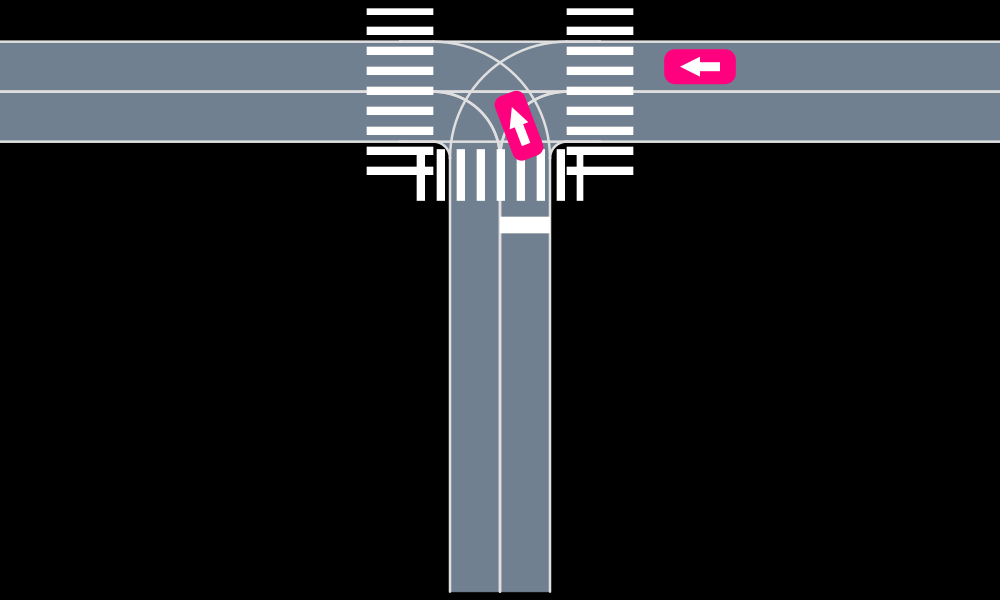

In [51]:
AutoViz.render(state2scene(mdp, sc), env, cam=FitToContentCamera(0.0))

In [54]:
mdp.car_model
lane = get_lane(mdp.env.roadway, s.car)
set_direction!(mdp.car_model, lane, mdp.env.roadway)
# car_actions, car_actions_probs = get_distribution(mdp.car_model)
# car_ps = VehicleState[]
# for (i, car_a) in enumerate(car_actions)
#     p_a = car_actions_probs[i]
#     car_p = propagate(s.car, car_a, mdp.env.roadway, mdp.ΔT)
#     println(" True car " , car_p)
#     car_v_space = get_car_vspace(mdp.env, mdp.vel_res)
#     itp_car_ps, itp_car_weights = interpolate_state(car_p, car_v_space)
#     for car in itp_car_ps
#         println(car)
#     end
# end


In [55]:
mdp.car_model.dir

1

In [56]:
lane.exits

2-element Array{AutomotiveDrivingModels.LaneConnection,1}:
 LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {10, 1})
 LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {10, 1})

In [ ]:
routes = get_car_routes(mdp.env)

In [29]:
states(mdp)[8417].car

VehicleState(VecSE2({9.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.875000}, {1, 1}), 21.000, 0.000, 0.000), 2.000)

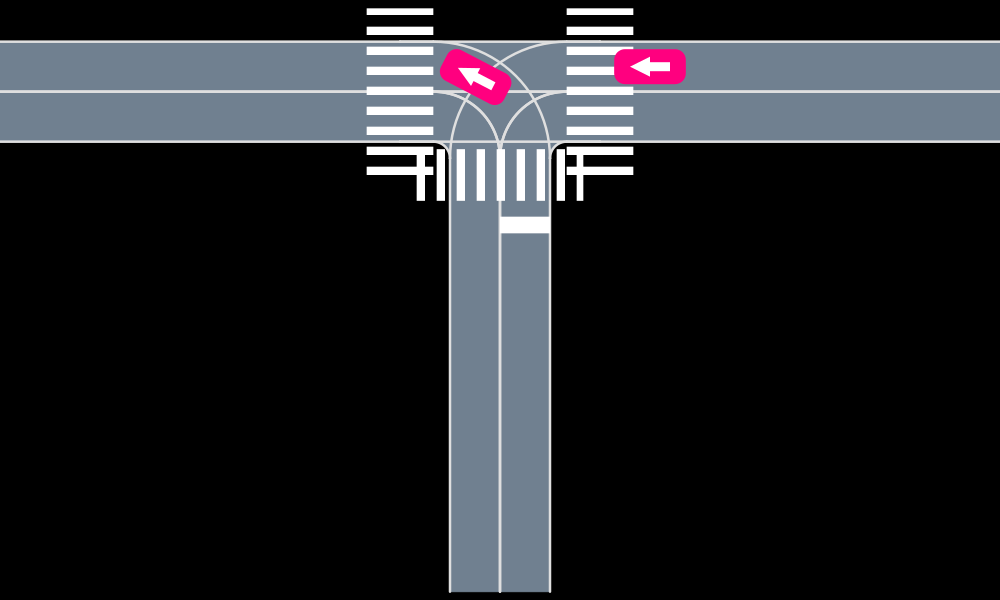

In [25]:
sp = states(mdp)[8417]
sc = state2scene(mdp, sp)
AutoViz.render(sc, env, cam=FitToContentCamera(0.))

In [21]:
P[8417]

0.9998529784742464

In [19]:
lane = env.roadway[LaneTag(12,1)].exits

1-element Array{AutomotiveDrivingModels.LaneConnection,1}:
 LaneConnection(D, CurveIndex(24, 1.000), RoadIndex({1, 0.000000}, {5, 1})

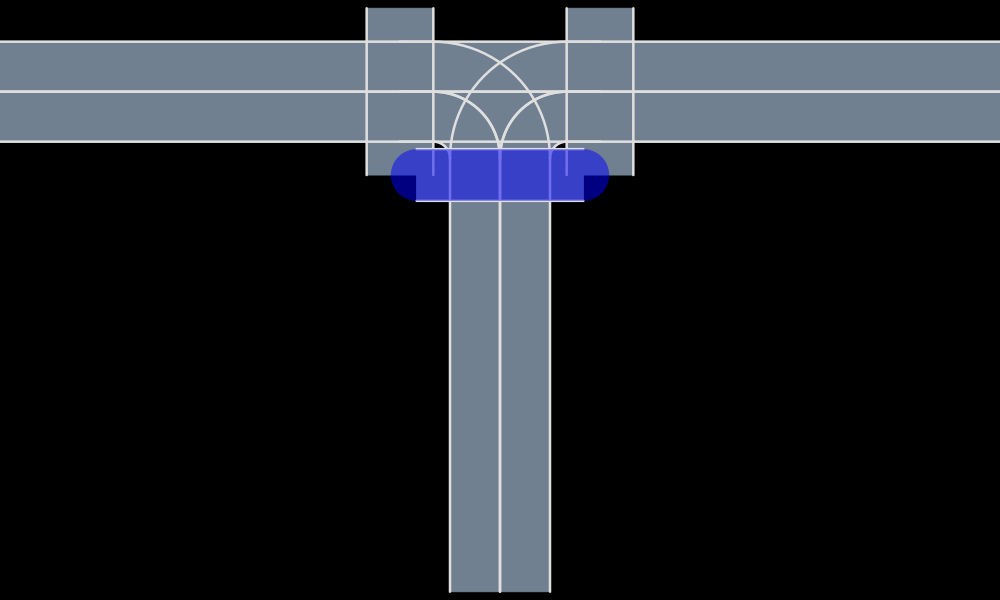

In [24]:
scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

i=19
render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))